Importing the libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import os
import random
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

Fetch the data

In [2]:
!gdown --id 1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j
To: /content/animal_image.zip
100% 30.3M/30.3M [00:00<00:00, 46.4MB/s]


In [3]:
!unzip animal_image.zip

Archive:  animal_image.zip
   creating: animal_image/test/
   creating: animal_image/test/animal chicken/
  inflating: animal_image/test/animal chicken/0U5DJ4AHL7U8.jpg  
  inflating: animal_image/test/animal chicken/0YRRH5UO983S.jpg  
  inflating: animal_image/test/animal chicken/17ZH2WHTIPL8.jpg  
  inflating: animal_image/test/animal chicken/1O9LZD4GDLEG.jpg  
  inflating: animal_image/test/animal chicken/1OX6JD87ZL6M.jpg  
  inflating: animal_image/test/animal chicken/1WHCYYP4QBBB.jpg  
  inflating: animal_image/test/animal chicken/1ZLB7IELNMCD.jpg  
  inflating: animal_image/test/animal chicken/21AEDSI4YQ9L.jpg  
  inflating: animal_image/test/animal chicken/2GGVG9VUE5VP.jpg  
  inflating: animal_image/test/animal chicken/2IH2F7SXSTFS.jpg  
  inflating: animal_image/test/animal chicken/2MD30734HGEK.jpg  
  inflating: animal_image/test/animal chicken/30XSIDP797YK.jpg  
  inflating: animal_image/test/animal chicken/37ROYA9ANCBW.jpg  
  inflating: animal_image/test/animal chicken/3LM

In [4]:
IMAGE_SIZE = (224,224,3)

In [5]:
train_path="animal_image/train"
test_path="animal_image/test"
val_path="animal_image/val"

In [6]:
x_train = []
num_samples_per_folder = 332  # Specify the number of samples to take from each folder

for folder in os.listdir(train_path):
    sub_path = os.path.join(train_path, folder)

    image_list = os.listdir(sub_path)
    random.shuffle(image_list)
    for img in image_list[:num_samples_per_folder]:
        image_path = os.path.join(sub_path, img)
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (224, 224))

        x_train.append(img_arr)

In [7]:
x_test = []
num_samples_per_folder = 115  

for folder in os.listdir(test_path):
    sub_path = os.path.join(test_path, folder)
    image_list = os.listdir(sub_path)
    random.shuffle(image_list)
    for img in image_list[:num_samples_per_folder]:
        image_path = os.path.join(sub_path, img)
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (224, 224))

        x_test.append(img_arr)

In [8]:
x_val = []
num_samples_per_folder = 52  

for folder in os.listdir(val_path):
    sub_path = os.path.join(val_path, folder)
    image_list = os.listdir(sub_path)
    random.shuffle(image_list)
    for img in image_list[:num_samples_per_folder]:
        image_path = os.path.join(sub_path, img)
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (224, 224))

        x_val.append(img_arr)
     

In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 664 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


In [11]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [12]:
training_set.class_indices

{'animal chicken': 0, 'animal duck': 1}

In [13]:
train_y.shape,test_y.shape,val_y.shape

((664,), (230,), (104,))

In [14]:
vgg = VGG19(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
#We are not going to train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [15]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
21/21 [==============================] - 513s 24s/step - loss: 1.3005 - accuracy: 0.6160 - val_loss: 0.6018 - val_accuracy: 0.7019
Epoch 2/10
21/21 [==============================] - 527s 25s/step - loss: 0.3031 - accuracy: 0.8825 - val_loss: 0.4650 - val_accuracy: 0.8077
Epoch 3/10
21/21 [==============================] - 529s 25s/step - loss: 0.1529 - accuracy: 0.9428 - val_loss: 0.4716 - val_accuracy: 0.8462
Epoch 4/10
21/21 [==============================] - 525s 25s/step - loss: 0.1044 - accuracy: 0.9729 - val_loss: 0.3679 - val_accuracy: 0.8365
Epoch 5/10
21/21 [==============================] - 524s 25s/step - loss: 0.0706 - accuracy: 0.9910 - val_loss: 0.3861 - val_accuracy: 0.8750
Epoch 6/10
21/21 [==============================] - 523s 25s/step - loss: 0.0563 - accuracy: 0.9940 - val_loss: 0.3639 - val_accuracy: 0.8558
Epoch 7/10
21/21 [==============================] - 522s 25s/step - loss: 0.0453 - accuracy: 0.9970 - val_loss: 0.4325 - val_accuracy: 0.8750
Epoch 

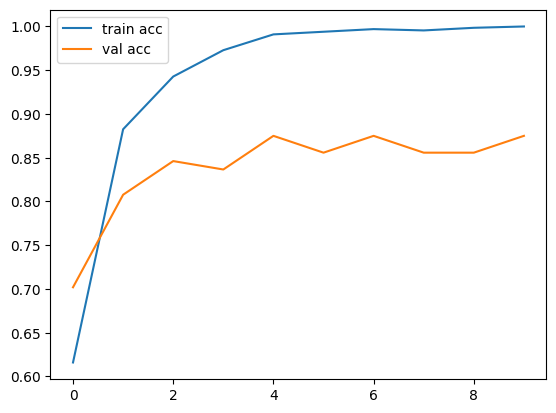

In [16]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()


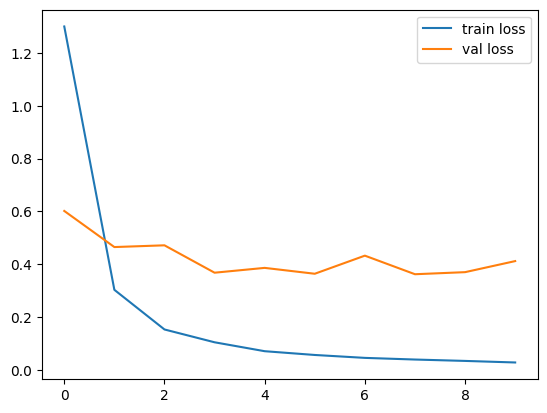

In [17]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()
     


In [18]:
model.evaluate(test_x,test_y,batch_size=32)


8/8 [==============================] - 154s 19s/step - loss: 0.2297 - accuracy: 0.8826


[0.2297479212284088, 0.8826087117195129]

In [19]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)


8/8 [==============================] - 154s 19s/step


In [20]:
#get classification report
print(classification_report(y_pred,test_y))


              precision    recall  f1-score   support

           0       0.89      0.88      0.88       116
           1       0.88      0.89      0.88       114

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



In [21]:
#get confusion matrix
print(confusion_matrix(y_pred,test_y))

[[102  14]
 [ 13 101]]


In [22]:
y_test_word =[]
for i in test_y:
  if i==0:
    y_test_word.append('chicken')
  else:
    y_test_word.append('duck')

y_pred_word =[]
for i in y_pred:
  if i==0:
    y_pred_word.append('chicken')
  else:
    y_pred_word.append('duck')

In [23]:
# Display Subplots
def disp_subplots(image, shape, titles, sup_title, axes, figsize, cmap=None):
  fig, ax = plt.subplots(shape[0], shape[1], figsize=figsize)
  try:
    ax = ax.ravel()
  except:
    pass
    
  for i in range(len(image)):
    if cmap is None:
      ax[i].imshow(image[i])
    else:
      ax[i].imshow(image[i], cmap=cmap)

    if axes[i] is None:
      ax[i].set_xticks([])
      ax[i].set_yticks([])

    if titles[i] is not None:
      ax[i].set_title(titles[i])

  if sup_title is not None:
    fig.suptitle(sup_title, fontsize=18)
  plt.show()


In [24]:
random.seed(40)

image_idx = random.sample(range(len(y_pred)), 9)
images=[]
titles=[]
for idx in image_idx:
    titles.append(f'Actual Label:{y_test_word[idx]}, Predicted Label:{y_pred_word[idx]}')
    images.append(cv2.cvtColor(x_test[idx], cv2.COLOR_BGR2RGB))

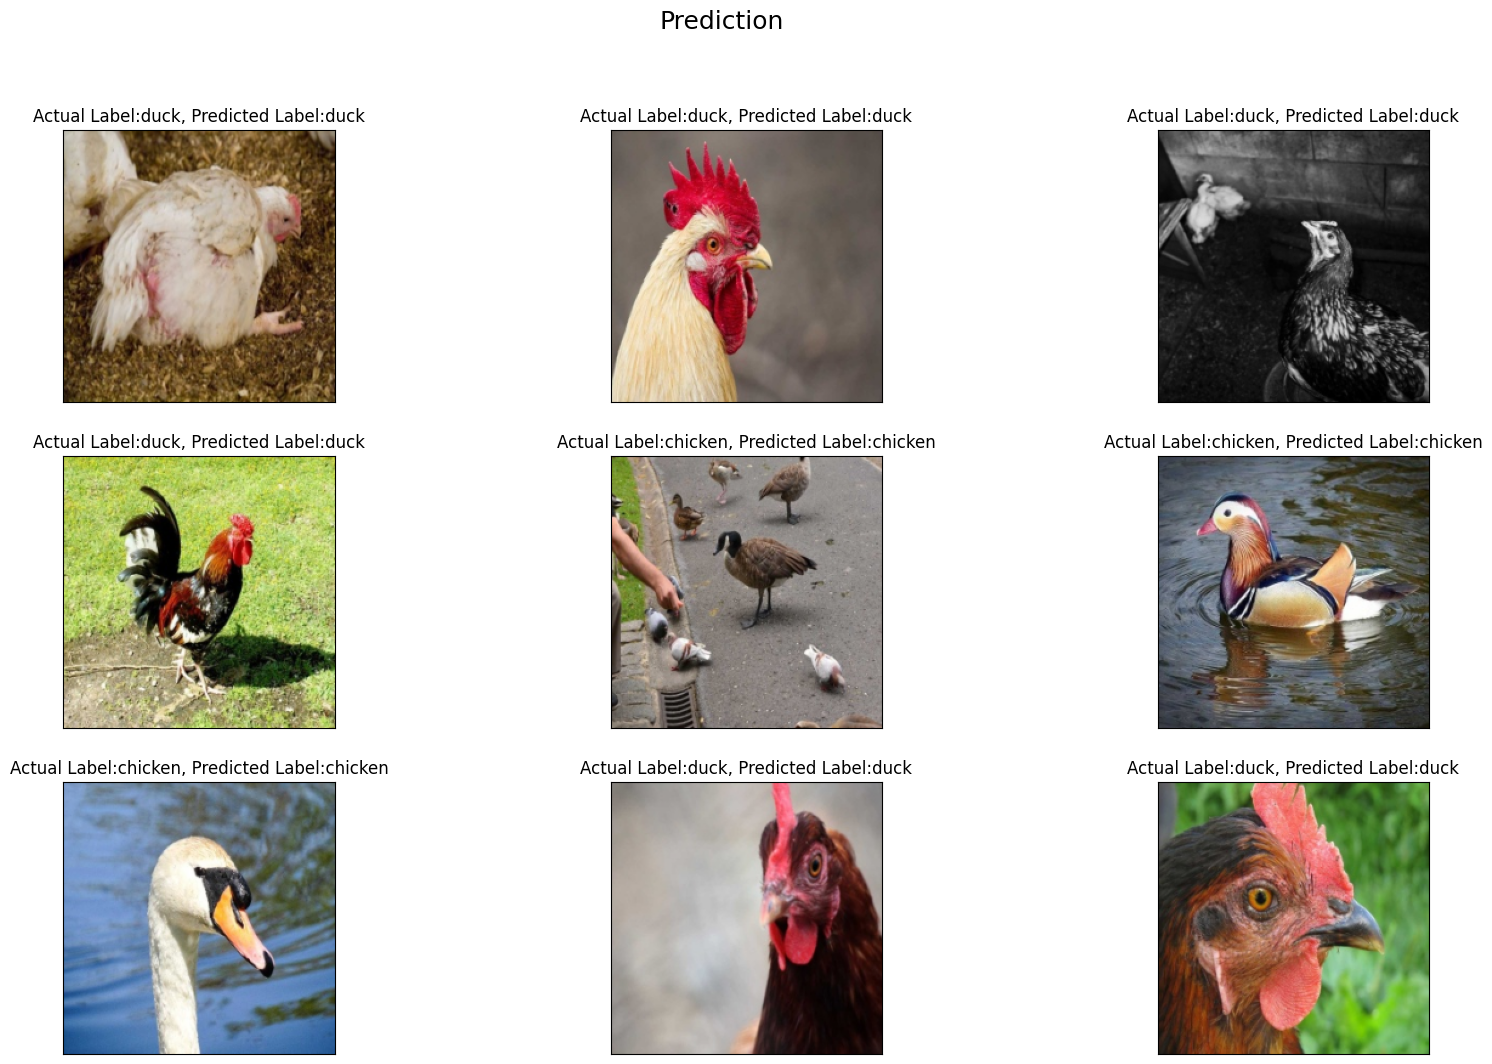

In [25]:
disp_subplots(images, (3,3), titles, 'Prediction', [None]*9, (20,12), cmap='gray')
